In [1]:
#import statements
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import scipy.stats as stats
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer,RobustScaler,MinMaxScaler

import env
import get_function as gf

**Aquire**

In [2]:
# Import from zillow
df = gf.get_zillow_data()

In [3]:
df.head()

,parcelid,logerror,transactiondate,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,12177905,-0.103410,2017-01-01,2288172,12177905,NaN,None,None,3.0,4.0,...,NaN,None,108918.0,145143.0,2016.0,36225.0,1777.51,None,NaN,6.037300e+13
1,12095076,-0.001011,2017-01-01,781532,12095076,1.0,None,None,3.0,4.0,...,NaN,None,276684.0,773303.0,2016.0,496619.0,9516.26,None,NaN,6.037461e+13
2,12069064,0.101723,2017-01-01,870991,12069064,NaN,None,None,1.0,2.0,...,NaN,None,18890.0,218552.0,2016.0,199662.0,2366.08,None,NaN,6.037302e+13
3,12790562,-0.040966,2017-01-02,1246926,12790562,NaN,None,None,3.0,4.0,...,NaN,None,177527.0,220583.0,2016.0,43056.0,3104.19,None,NaN,6.037500e+13
4,11104527,0.005963,2017-01-02,1639362,11104527,1.0,None,None,3.0,4.0,...,NaN,None,271715.0,430108.0,2016.0,158393.0,6103.36,None,NaN,6.037920e+13


In [4]:
df.shape

(33701, 62)

**Prepare**

In [5]:
# dropp columns with less than 60% of data non-null and rows with more than 75% of data non-null
df = gf.handle_missing_values(df, prop_required_column = .6, prop_required_row = .75)

In [6]:
df.isnull().sum()

parcelid                          0
logerror                          0
transactiondate                   0
id                                0
parcelid                          0
bathroomcnt                       0
bedroomcnt                        0
buildingqualitytypeid           127
calculatedbathnbr                 0
calculatedfinishedsquarefeet      0
finishedsquarefeet12              0
fips                              0
fullbathcnt                       0
heatingorsystemtypeid           536
latitude                          0
longitude                         0
lotsizesquarefeet               304
propertycountylandusecode         0
propertylandusetypeid             0
propertyzoningdesc               68
rawcensustractandblock            0
regionidcity                    694
regionidcounty                    0
regionidzip                      12
roomcnt                           0
unitcnt                           0
yearbuilt                         7
structuretaxvaluedollarcnt  

In [7]:
df.shape

(33701, 33)

In [8]:
# removing unnessesery columns
df = gf.remove_columns(df, ['roomcnt','assessmentyear','unitcnt','regionidzip','regionidcounty','propertylandusetypeid','propertycountylandusecode','fullbathcnt','calculatedbathnbr','rawcensustractandblock','finishedsquarefeet12','parcelid','transactiondate','id','regionidcity','buildingqualitytypeid','heatingorsystemtypeid','propertyzoningdesc','censustractandblock'])

In [9]:
df.isnull().sum()

logerror                          0
bathroomcnt                       0
bedroomcnt                        0
calculatedfinishedsquarefeet      0
fips                              0
latitude                          0
longitude                         0
lotsizesquarefeet               304
yearbuilt                         7
structuretaxvaluedollarcnt       60
taxvaluedollarcnt                 0
landtaxvaluedollarcnt             0
taxamount                         4
dtype: int64

In [10]:
df.shape

(33701, 13)

In [11]:
df = df.rename(columns={'lotsizesquarefeet':'lot_square_feet','calculatedfinishedsquarefeet':'home_square_feet', 'logerror': 'target','bathroomcnt': 'bathroom', 'bedroomcnt': 'bedroom','structuretaxvaluedollarcnt':'structure_value','taxvaluedollarcnt': 'total_value','landtaxvaluedollarcnt':'land_value','taxamoun':'tax_amount','taxamount':'tax_amount','yearbuilt':'year_built'})

In [12]:
# Covert year built into age years

df['age']= 2017 - df.year_built

In [13]:
# Drop year built because we added age column

df.drop(columns='year_built',inplace=True)

In [14]:
# Delete rows where tax value amount does not equal land value + structure value

np.where(df.total_value - (df.land_value + df.structure_value) != 0)

(array([  397,   875,   878,   940,   959,  1203,  1278,  1324,  1726,
         1750,  1927,  2370,  4472,  4703,  5251,  5463,  5514,  5723,
         5783,  6108,  6887,  7005,  8739,  9386, 10622, 11406, 11585,
        12340, 12850, 13048, 13655, 13739, 14337, 14865, 15060, 18902,
        19494, 19762, 20312, 20614, 20917, 21217, 21285, 21661, 22036,
        22183, 22185, 23676, 25773, 26889, 27696, 28695, 31024, 31553,
        31708, 32148, 32171, 32679, 33018, 33032]),)

In [15]:
df.loc[31024]

# 397, 878,   940,   959,  1203,  1278,  1324,  1726,
# 1750,  1927,  2370,  4472,  4703,  5251,  5463,  5514,  5723,
# 5783,  6108,  6887,  7005,  8739,  9386, 10622, 11406, 11585,
# 12340, 12850, 13048, 13655, 13739, 14337, 14865, 15060, 18902,
# 19494, 19762, 20312, 20614, 20917, 21217, 21285, 21661, 22036,
# 22183, 22185, 23676, 25773, 26889, 27696, 28695, 31024, 31553,
# 31708, 32148, 32171, 32679, 33018, 33032]

target              8.249599e-02
bathroom            1.000000e+00
bedroom             3.000000e+00
home_square_feet    1.460000e+03
fips                6.037000e+03
latitude            3.411261e+07
longitude          -1.180782e+08
lot_square_feet     9.099000e+03
structure_value              NaN
total_value         7.898640e+05
land_value          7.898640e+05
tax_amount          9.132300e+03
age                 6.200000e+01
Name: 31024, dtype: float64

In [16]:
df.drop([397,   875,   878,   940,   959,  1203,  1278,  1324,  1726,
         1750,  1927,  2370,  4472,  4703,  5251,  5463,  5514,  5723,
         5783,  6108,  6887,  7005,  8739,  9386, 10622, 11406, 11585,
        12340, 12850, 13048, 13655, 13739, 14337, 14865, 15060, 18902,
        19494, 19762, 20312, 20614, 20917, 21217, 21285, 21661, 22036,
        22183, 22185, 23676, 25773, 26889, 27696, 28695, 31024, 31553,
        31708, 32148, 32171, 32679, 33018, 33032],axis=0,inplace=True)

In [17]:
df.isnull().sum()

target                0
bathroom              0
bedroom               0
home_square_feet      0
fips                  0
latitude              0
longitude             0
lot_square_feet     291
structure_value       0
total_value           0
land_value            0
tax_amount            3
age                   7
dtype: int64

In [18]:
# Split data (train & test)

train, test = gf.split_my_data(df, .80, 123)

In [19]:
# impute lot_square_feet,structure_value, and tax_amount for the mean

train = gf.imputer_9000(train,['lot_square_feet','tax_amount', 'age'],'mean')
test = gf.imputer_9000(test,['lot_square_feet','tax_amount', 'age'],'mean')

In [20]:
train['home_value_square_footage'] = train.structure_value/train.home_square_feet
train['land_value_square_footage'] = train.land_value/train.lot_square_feet

test['home_value_square_footage'] = test.structure_value/test.home_square_feet
test['land_value_square_footage'] = test.land_value/test.lot_square_feet

In [21]:
train.isnull().sum()

target                       0
bathroom                     0
bedroom                      0
home_square_feet             0
fips                         0
latitude                     0
longitude                    0
lot_square_feet              0
structure_value              0
total_value                  0
land_value                   0
tax_amount                   0
age                          0
home_value_square_footage    0
land_value_square_footage    0
dtype: int64

In [22]:
test.isnull().sum()

target                       0
bathroom                     0
bedroom                      0
home_square_feet             0
fips                         0
latitude                     0
longitude                    0
lot_square_feet              0
structure_value              0
total_value                  0
land_value                   0
tax_amount                   0
age                          0
home_value_square_footage    0
land_value_square_footage    0
dtype: int64

In [23]:
train.head()

,target,bathroom,bedroom,home_square_feet,fips,latitude,longitude,lot_square_feet,structure_value,total_value,land_value,tax_amount,age,home_value_square_footage,land_value_square_footage
33257,0.005565,3.0,4.0,1673.0,6037.0,33985663.0,-118229161.0,3000.0,126192.0,227194.0,101002.0,3505.67,18.0,75.428571,33.667333
8306,0.452906,1.0,3.0,950.0,6037.0,33941666.0,-118235240.0,3251.0,116496.0,191571.0,75075.0,2495.60,52.0,122.627368,23.092894
25859,0.020907,2.0,3.0,1256.0,6037.0,34209673.0,-118628052.0,7525.0,46269.0,84214.0,37945.0,1137.12,56.0,36.838376,5.042525
30676,0.012864,2.0,3.0,1984.0,6037.0,34129558.0,-117719482.0,15368.0,242729.0,683452.0,440723.0,9630.60,40.0,122.343246,28.677967
30916,0.007597,2.0,4.0,2016.0,6037.0,34013213.0,-117863106.0,7595.0,179535.0,223522.0,43987.0,2839.42,40.0,89.055060,5.791573


In [24]:
test.head()

,target,bathroom,bedroom,home_square_feet,fips,latitude,longitude,lot_square_feet,structure_value,total_value,land_value,tax_amount,age,home_value_square_footage,land_value_square_footage
33106,-0.027917,3.0,5.0,3083.0,6037.0,34671833.0,-118084245.0,11565.0,250104.0,309853.0,59749.0,4751.76,4.0,81.123581,5.166364
535,0.008490,1.0,3.0,1115.0,6037.0,33978427.0,-118063427.0,5697.0,96432.0,292670.0,196238.0,3732.85,67.0,86.486099,34.445849
6513,-0.034321,3.0,6.0,2176.0,6037.0,34032118.0,-118303539.0,7184.0,159154.0,424413.0,265259.0,5212.80,95.0,73.140625,36.923580
25153,-0.114455,2.0,2.0,1385.0,6037.0,34010163.0,-118309306.0,5876.0,29632.0,71701.0,42069.0,960.64,105.0,21.394946,7.159462
14729,0.070176,2.0,2.0,2209.0,6037.0,34043071.0,-118493656.0,9041.0,72049.0,228604.0,156555.0,3190.31,91.0,32.616116,17.316115


In [25]:
# Scaling dataframe in two ways

In [26]:
# Scale age, latitude, and longitude using MinMax scaler - why (to presrve distance better)

train = gf.scaler_min_max(train, ['age', 'latitude', 'longitude'])
test = gf.scaler_min_max(test, ['age', 'latitude', 'longitude'])

In [27]:
# Scale bathroom, bedroom, home_square_feet, lot_square_feet, structure_value, total_value, land_value, tax_amount using uniform scaler

# Scale columns using Uniform scaler (to smooth out the distribution and handle outliers)

train = gf.uniform_scaler(train,['bathroom', 'bedroom', 'home_square_feet', 'lot_square_feet', 'structure_value', 'total_value', 'land_value', 'tax_amount'])
test = gf.uniform_scaler(test,['bathroom', 'bedroom', 'home_square_feet', 'lot_square_feet', 'structure_value', 'total_value', 'land_value', 'tax_amount'])

In [28]:
X_train = train.drop(columns='target')
y_train = train[['target']]

In [29]:
X_train.head()

,fips,home_value_square_footage,land_value_square_footage,age,latitude,longitude,bathroom,bedroom,home_square_feet,lot_square_feet,structure_value,total_value,land_value,tax_amount
33257,6037.0,75.428571,33.667333,0.123188,0.436386,0.536519,0.808081,0.797980,0.570146,0.023314,0.513659,0.353399,0.348650,0.398947
8306,6037.0,122.627368,23.092894,0.369565,0.406621,0.531622,0.000000,0.439394,0.086700,0.028712,0.468921,0.292398,0.298502,0.261001
25859,6037.0,36.838376,5.042525,0.398551,0.587934,0.215137,0.474747,0.439394,0.291246,0.609963,0.126087,0.116949,0.175673,0.084909
30676,6037.0,122.343246,28.677967,0.282609,0.533734,0.947162,0.474747,0.439394,0.701362,0.900550,0.812084,0.823291,0.815276,0.857338
30916,6037.0,89.055060,5.791573,0.282609,0.455024,0.831446,0.474747,0.797980,0.711517,0.623167,0.694966,0.346976,0.203554,0.308010


In [30]:
y_train.head()

,target
33257,0.005565
8306,0.452906
25859,0.020907
30676,0.012864
30916,0.007597


In [31]:
train[train.target > 0].mean()

target                          0.081899
fips                         6037.004416
home_value_square_footage      90.518032
land_value_square_footage      40.968673
age                             0.418692
latitude                        0.526978
longitude                       0.524213
bathroom                        0.488470
bedroom                         0.515254
home_square_feet                0.518310
lot_square_feet                 0.506307
structure_value                 0.507789
total_value                     0.507428
land_value                      0.505919
tax_amount                      0.506962
dtype: float64

In [32]:
train[train.target < 0].mean()

target                         -0.068046
fips                         6037.003676
home_value_square_footage      90.428961
land_value_square_footage      39.519948
age                             0.433634
latitude                        0.530344
longitude                       0.528297
bathroom                        0.448830
bedroom                         0.481751
home_square_feet                0.477126
lot_square_feet                 0.491834
structure_value                 0.490066
total_value                     0.490615
land_value                      0.492507
tax_amount                      0.491223
dtype: float64

In [33]:
train.target.mean()

0.015217332551863352

In [34]:
train[train.target > 0].count()

target                       14944
fips                         14944
home_value_square_footage    14944
land_value_square_footage    14944
age                          14944
latitude                     14944
longitude                    14944
bathroom                     14944
bedroom                      14944
home_square_feet             14944
lot_square_feet              14944
structure_value              14944
total_value                  14944
land_value                   14944
tax_amount                   14944
dtype: int64

In [35]:
train[train.target < 0].count()

target                       11968
fips                         11968
home_value_square_footage    11968
land_value_square_footage    11968
age                          11968
latitude                     11968
longitude                    11968
bathroom                     11968
bedroom                      11968
home_square_feet             11968
lot_square_feet              11968
structure_value              11968
total_value                  11968
land_value                   11968
tax_amount                   11968
dtype: int64

In [36]:
train[train.target > 0].count() /(train[train.target > 0].count() + train[train.target < 0].count())

target                       0.555291
fips                         0.555291
home_value_square_footage    0.555291
land_value_square_footage    0.555291
age                          0.555291
latitude                     0.555291
longitude                    0.555291
bathroom                     0.555291
bedroom                      0.555291
home_square_feet             0.555291
lot_square_feet              0.555291
structure_value              0.555291
total_value                  0.555291
land_value                   0.555291
tax_amount                   0.555291
dtype: float64

Differinces in over and underestimation

over mean = .081

over %56

under mean = -.0680

under %44


In [37]:
stats.ttest_ind(train[train.target < 0].mean(),train[train.target > 0].mean())

Ttest_indResult(statistic=-0.00021801657840273504, pvalue=0.9998275938430903)

There is no significant differince in the overestimations and underestimations

In [38]:
train['absolute_target']= train.target.abs()

In [39]:
# plt.figure(figsize=(12,12))
# sns.heatmap(train.corr(), cmap='RdYlBu', annot=True, center=0)

In [40]:
# plt.figure(figsize=(22,22))
# sns.pairplot(train)
# plt.show()

In [41]:
# plt.figure(figsize=(22,22))
# sns.pairplot(train[['target', 'home_value_square_footage','land_value_square_footage']])
# plt.show()

home_value_square_footage and land_value_square_foortage show a correlation with logerror 

Going to try correlating home_value_square_footage and land_value_square_foortage  with longitude and latitude and see if a useful patrern emerges

   k           sse
0  1  2.156603e+08
1  2  1.328536e+08
2  3  9.908254e+07
3  4  7.820217e+07
4  5  6.368496e+07
5  6  5.350922e+07
6  7  4.565532e+07
7  8  3.894241e+07
8  9  3.372761e+07


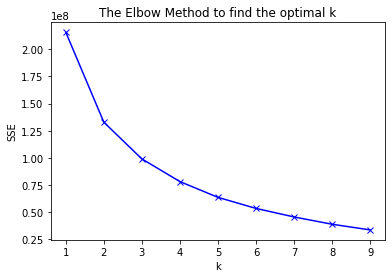

In [43]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()